In [1]:
import os

import subprocess
from pathlib import Path

import time
import numpy as np

from functools import partial
from jax.sharding import PartitionSpec as P, NamedSharding

import re
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
n_runs = 5

def collect_results(root: Path, min_T_A=128):
    """
    Walks through root/data_<fn> folders and returns a dict:
    results[(gpu, dtype, ndev)][T_A][N] = median_time
    """
    results = {}

    for path in root.rglob("N_*.npy"):
        # Expect directory: data/<gpu>/<dtype>/ndev_<k>/N_<N>_T_A_<TA>.npy
        try:
            gpu = path.parents[2].name
            dtype = path.parents[1].name
            ndev = int(path.parents[0].name.split("_")[-1])
        except Exception:
            continue

        m = re.match(r"N_(\d+)_T_A_(\d+)\.npy$", path.name)
        if not m:
            m = re.match(r"N_(\d+)_jax_native\.npy$", path.name)
            if not m:
                continue
            N = int(m.group(1))

            times = np.load(path)
            if times.size == 0:
                continue

            med = float(np.median(times))
            key = (gpu, dtype, ndev)
            results.setdefault(key, {}).setdefault("jax_native", {})[N] = med
        else:
            N = int(m.group(1))
            T_A = int(m.group(2))

            times = np.load(path)
            if times.size == 0:
                continue
            if T_A<min_T_A:
                continue
            med = float(np.median(times))
            key = (gpu, dtype, ndev)
            results.setdefault(key, {}).setdefault(T_A, {})[N] = med

    return results

# Results potrs

In [8]:

def plot_group_T_A_potrs(results, figpath):
    for (gpu, dtype, ndev), group in results.items():
        title = f"potrs: {gpu}_{dtype}_ndev={ndev}"
        fig, ax = plt.subplots(figsize=(7, 5))
        group_filtered = {
            key: group[key] for key in group.keys() if isinstance(key, int)
        }

        for T_A, runs in sorted(group_filtered.items()):
            Ns = sorted(runs.keys())
            meds = [runs[N] for N in Ns]
            ax.plot(Ns, meds, marker="o", label=f"T_A={T_A}")
            
        try:
            runs = results[(gpu, dtype, 1)]["jax_native"]
            Ns = sorted(runs.keys())
            meds = [runs[N] for N in Ns]
            ax.plot(Ns, meds, marker="o", label=f"chosolve", color="black")
        except KeyError:
            pass
        if gpu == "NVIDIA_A100-SXM4-40GB":
            ax.vlines(50000,1e-4, 1e2, linestyle='--', color='black', label=f"chosolve max on {gpu}", zorder=-1)
            # if ndev==1:
            #     ax.vlines(68000,1e-4, 1e2, linestyle='--', color='green', label=f"JAXMg.potrs max on {gpu}", zorder=-1)
        elif gpu == "NVIDIA_A100-SXM4-80GB":
            ax.vlines(58000,1e-4, 1e2, linestyle='--', color='black', label=f"chosolve max on {gpu}", zorder=-1)
            # if ndev==1:
            #     ax.vlines(68000,1e-4, 1e2, linestyle='--', color='green', label=f"JAXMg.potrs max on {gpu}", zorder=-1)
                       
        # try:
        # ax.set_xscale("log", base=10)
        # except TypeError:
            # ax.set_xscale("log", basex=2)
        ax.set_yscale("log")
        ax.set_xlabel("N")
        ax.set_ylabel("Median time [s]")
        ax.set_ylim([1e-4, 1e3])
        ax.set_ylabel("Median time [s]")
        ax.set_title(title)
        ax.grid(True, which="both", linestyle="--", alpha=0.3)
        ax.legend(loc="upper left")
        fig.tight_layout()
        fig.savefig(figpath / f"T_A_potrf_{title}.pdf", bbox_inches="tight")
        plt.show()


def plot_group_ndev_potrs(results, figpath):
    data_plot = {}
    for (gpu, dtype, ndev), group in results.items():
        for T_A, runs in group.items():
            sorted_runs = sorted(runs.items(), key=lambda x: x[0])
            Ns = [k for k, v in sorted_runs]
            meds = [v for k, v in sorted_runs]
            data_plot.setdefault((gpu, dtype, T_A), {}).setdefault(ndev, (Ns, meds))
    for gpu, dtype, T_A in data_plot.keys():
        fig, ax = plt.subplots(figsize=(7, 5))
        title = f"potrs: {gpu}_{dtype}_T_A={T_A}"
        for ndev in data_plot[(gpu, dtype, T_A)].keys():
            x, y = data_plot[(gpu, dtype, T_A)][ndev]
            ax.plot(x, y, marker="o", label=f"ndev={ndev}")

            try:
                x, y = data_plot[(gpu, dtype, "chosolve")][1]
                ax.plot(x, y, marker="o", label=f"chosolve", color="black")
            except KeyError:
                pass
        try:
            ax.set_xscale("log", base=2)
        except TypeError:
            ax.set_xscale("log", basex=2)
        ax.set_yscale("log")

        ax.set_xlabel("N")
        ax.set_ylabel("Median time [s]")
        ax.set_ylim([1e-4, 1e2])
        ax.set_title(title)
        ax.grid(True, which="both", linestyle="--", alpha=0.3)
        ax.legend()
        fig.tight_layout()
        fig.savefig(figpath / f"ndev_potrf_{title}.pdf", bbox_inches="tight")
        plt.show()


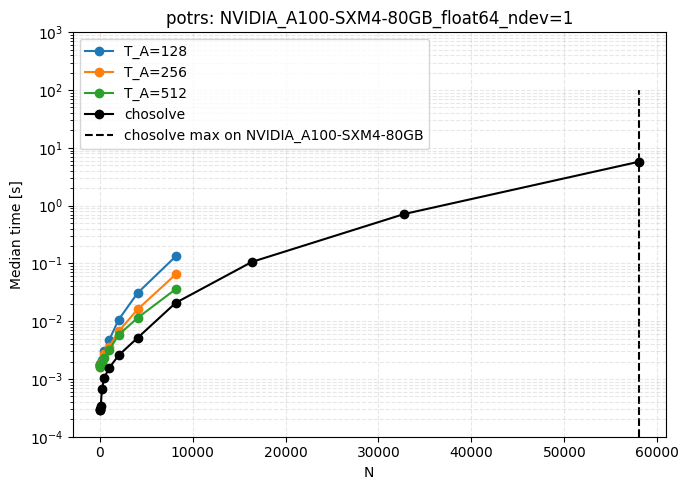

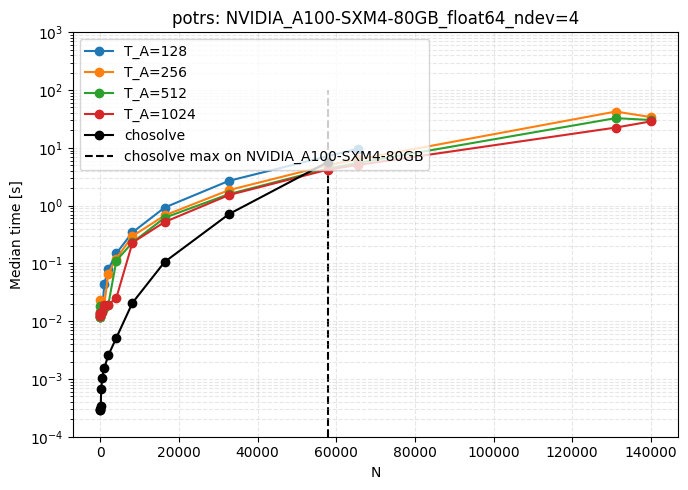

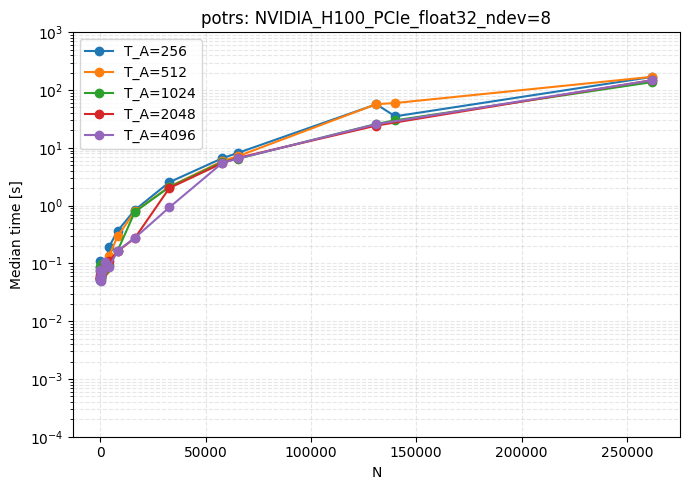

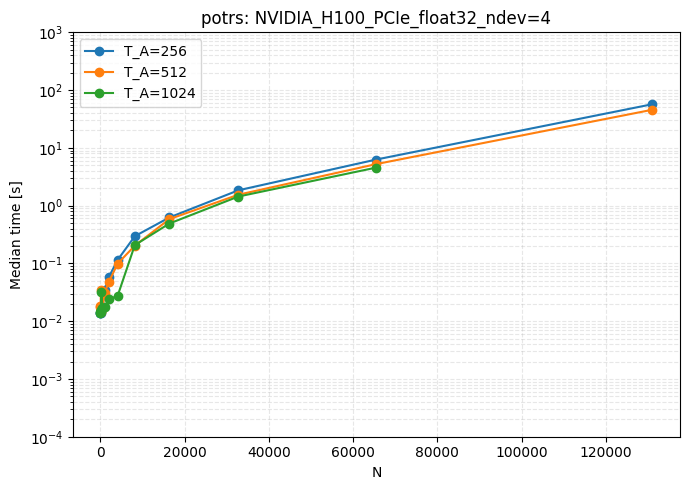

In [9]:
root = Path("../../benchmark/spmd/data_potrs")
figpath = Path("./figures")
results = collect_results(root)
if not results:
    raise SystemExit("No .npy results found.")

plot_group_T_A_potrs(results, figpath)
# plot_group_ndev(results, figpath)

# Results syevd

In [47]:
def plot_group_T_A_syevd(results, figpath):
    for (gpu, dtype, ndev), group in results.items():
        title = f"syevd: {gpu}_{dtype}_ndev={ndev}"
        fig, ax = plt.subplots(figsize=(7, 5))
        group_filtered = {
            key: group[key] for key in group.keys() if isinstance(key, int)
        }

        for T_A, runs in sorted(group_filtered.items()):
            Ns = sorted(runs.keys())
            meds = [runs[N] for N in Ns]
            ax.plot(Ns, meds, marker="o", label=f"T_A={T_A}")
            
        try:
            runs = results[(gpu, dtype, 1)]["jax_native"]
            Ns = sorted(runs.keys())
            meds = [runs[N] for N in Ns]
            ax.plot(Ns, meds, marker="o", label=f"eigh", color="black")
        except KeyError:
            pass
        # if gpu == "NVIDIA_A100-SXM4-40GB":
        #     ax.vlines(50000,1e-4, 1e2, linestyle='--', color='black', label=f"chosolve max on {gpu}", zorder=-1)
        #     if ndev==1:
        #         ax.vlines(68000,1e-4, 1e2, linestyle='--', color='green', label=f"JAXMg.potrs max on {gpu}", zorder=-1)
        # elif gpu == "NVIDIA_A100-SXM4-80GB":
        #     ax.vlines(58000,1e-4, 1e2, linestyle='--', color='black', label=f"chosolve max on {gpu}", zorder=-1)
        #     if ndev==1:
        #         ax.vlines(68000,1e-4, 1e2, linestyle='--', color='green', label=f"JAXMg.potrs max on {gpu}", zorder=-1)
                       
        # try:
        # ax.set_xscale("log", base=10)
        # except TypeError:
            # ax.set_xscale("log", basex=2)
        ax.set_yscale("log")
        ax.set_xlabel("N")
        ax.set_ylabel("Median time [s]")
        ax.set_ylim([1e-4, 1e3])
        ax.set_ylabel("Median time [s]")
        ax.set_title(title)
        ax.grid(True, which="both", linestyle="--", alpha=0.3)
        ax.legend(loc="upper left")
        fig.tight_layout()
        fig.savefig(figpath / f"T_A_syevd_{title}.pdf", bbox_inches="tight")
        plt.show()


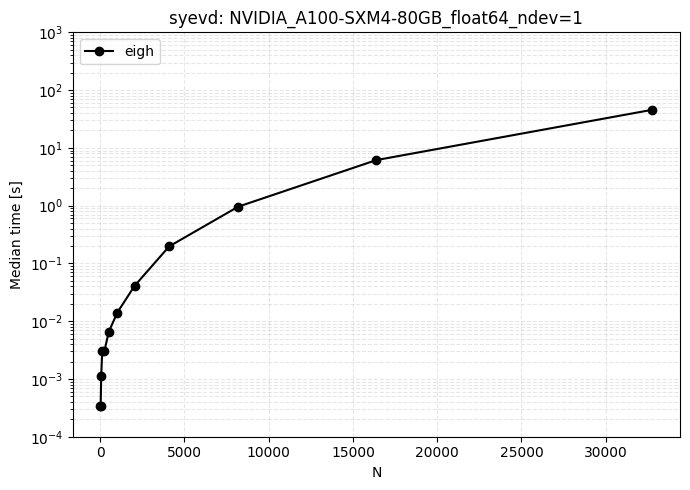

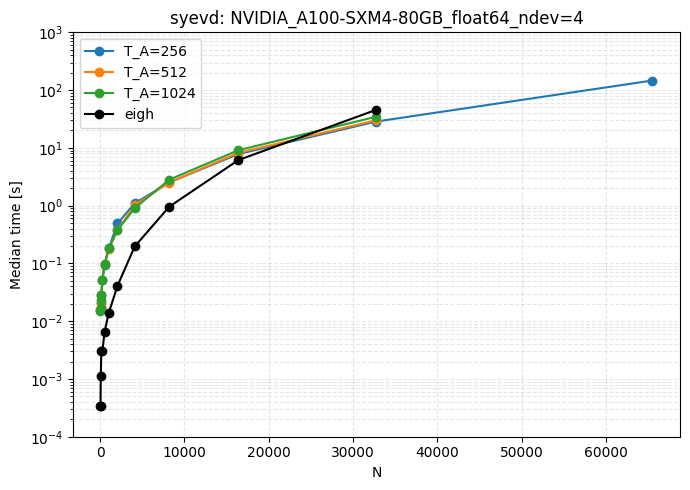

In [48]:
root = Path("../../benchmark/spmd/data_syevd")
figpath = Path("./figures")
results = collect_results(root)
if not results:
    raise SystemExit("No .npy results found.")

plot_group_T_A_syevd(results, figpath)
# plot_group_ndev(results, figpath)